In [1]:
import pandas as pd
import numpy as np
import re
import string
import gensim
import time
import json


import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

import multiprocessing as mp
from spellchecker import SpellChecker

import torch
import torch.nn as nn
import torch.optim as optim
import math
from argparse import Namespace

from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import codecs

# Init

In [2]:
if not nltk.find('corpora/wordnet'):
     nltk.download('wordnet')
porter_stemmer  = PorterStemmer()
lemmatizer      = WordNetLemmatizer()
regex_tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
spell  = SpellChecker()
one_hot_vectorizer = CountVectorizer(binary=True)
args = Namespace(
    # Data and Path hyper parameters
    degree_injury_file="./data/degreeinjury.csv",
    injury_bodyparts_file="./data/injurybodyparts.csv",
    NER_file="./data/ner.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.h5",
    save_dir="model_storage/document_classification",
    # Model hyper parameters
    glove_filepath='./Glove/glove.6B.200d.txt', 
    use_glove=True,
    embedding_size=150, 
    # Training hyper parameter
    window_size=5,
    val_proportion=0.1,
    test_proportion=0.2,
    learning_rate = 0.001,
    seed=666,
    dropout_p=0.1, 
    batch_size=256, 
    num_epochs=100, 
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

## Functions

In [3]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def make_embedding_matrix(glove_filepath, words):
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings, embedding_size

def load_glove_from_file(glove_filepath):
    word_to_index = {}
    embeddings = []
    with open(glove_filepath, encoding="utf8") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def clean_text(text):
    txt = ''
    txt = txt.strip()
    txt = re.sub(r"([.,!?])", r" \1 ", txt)
    for word in tokenize(text):
        # The EE is short hand on employee
        if word=='ee' or word == 'EE':
            txt += ' employee '
        elif word in string.punctuation:
            txt = txt + ' ' +word
        elif len(word)>2:
            word = spell.correction(word)
            txt = txt + ' ' + word.lower().strip()
    txt = re.sub(r"[^a-zA-Z.,!?]+", r" ", txt)
    return txt.strip()

def tokenize(text):
    return nltk.word_tokenize(text)

def stem(words, df=False):
    stemmed_words=[porter_stemmer.stem(word) for word in words]
    if df:
        return pd.DataFrame({'original': words,'stemmed': stemmed_words})
    return stemmed_words

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

def lemmatize(words, df=False):
    lemmatized_words=[]
    tagged_sent = nltk.pos_tag(words)
    
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or nltk.corpus.wordnet.NOUN
        if wordnet_pos is None:
            spell.correction(lemmatized_words.append(lemmatizer.lemmatize(tag[0])))
        else:
            spell.correction(lemmatized_words.append(lemmatizer.lemmatize(tag[0], pos=wordnet_pos)))
    
    if df:
        return pd.DataFrame({'original': words,'lemmatized': lemmatized_words})
    return lemmatized_words

def lemmatize_word(word):
    tagged_sent = nltk.pos_tag([word])
    wordnet_pos = get_wordnet_pos(tagged_sent[0][1]) or nltk.corpus.wordnet.NOUN
    if wordnet_pos is None:
        return lemmatizer.lemmatize(tagged_sent[0][0])
    else:
        return lemmatizer.lemmatize(tagged_sent[0][0], pos=wordnet_pos)

def SK_TFIDF_stopwords(corpus, vectorizer):
    vectorizer.fit(corpus)
    X = vectorizer.transform(corpus)
    return vectorizer.stop_words_, X

def get_words(texts):
    words = []
    for text in texts:
        words+=regex_tokenizer.tokenize(text)
    return np.asarray(words).reshape(-1, 1)

def OHE_2D(sent, sparse=False):
    enc = OneHotEncoder(handle_unknown='ignore', sparse=sparse)
    words=[]
    for w in sent.values:
        words += w
    X = enc.fit(np.array(words).reshape(-1,1))
    
    # Round up to without unit digit
    ohe = sent.apply(lambda x: enc.transform(np.array(x).reshape(-1,1)))
    maxwords = max([len(x) for x in ohe])
    maxwords = math.ceil(maxwords/10)*10
    dim = len(ohe[0][0])
    print('Vector length:          ', dim, '\nMaximum number of words:', maxwords)

    return [np.concatenate((x, np.zeros((maxwords - len(x), dim))), axis=0) for x in ohe]

def OHE_1D(sent):
    corpus = [' '.join(x) for x in sent.values]
    print(corpus[0])
    ohe = CountVectorizer(binary=True)
    return pd.DataFrame(ohe.fit_transform(corpus).todense(), columns=ohe.get_feature_names())

def spell_check(words):
    return [spell.correction(word) for word in words]

def remove_stopwords(words, stopwords):
    return [w for w in words if w not in stopwords]

def split_save(data, path, test=0.2, valid= 0.1, stratify=True):
    if stratify:
        train, test  = train_test_split(data,  test_size=test, random_state=666, shuffle=True, stratify=data['target'])
        train, valid = train_test_split(train, test_size=valid, random_state=666, shuffle=True, stratify=train['target'])
    else:
        train, test  = train_test_split(data,  test_size=test, random_state=666, shuffle=True)
        train, valid = train_test_split(train, test_size=valid, random_state=666, shuffle=True)
    train['split'] = 'train'
    test['split']  = 'test'
    valid['split'] = 'val'
    pd.concat([train, valid, test]).to_csv(path, index=False)

# Clean Narrative
#### Clean Narrative is computionally expensive run if only necessary

In [4]:
df = pd.read_csv('us_data_2000.csv')
df = df[['DEGREE_INJURY', 'DEGREE_INJURY_CD', 'INJ_BODY_PART_CD', 'INJ_BODY_PART', 'NARRATIVE']]
df.head(1)

,DEGREE_INJURY,DEGREE_INJURY_CD,INJ_BODY_PART_CD,INJ_BODY_PART,NARRATIVE
0,DAYS RESTRICTED ACTIVITY ONLY,5,700,MULTIPLE PARTS (MORE THAN ONE MAJOR),Employee was cleaning up at the Primary Crushe...


In [5]:
df.isnull().any()

DEGREE_INJURY       False
DEGREE_INJURY_CD    False
INJ_BODY_PART_CD    False
INJ_BODY_PART       False
NARRATIVE           False
dtype: bool

In [6]:
print('NARRATIVE NaN count:   ', df[df['NARRATIVE'].isna()].shape[0])
print('NARRATIVE len>10 count:', df[df['NARRATIVE'].str.len() < 10].shape[0])
print('\nDEGREE_INJURY_CD "?" count: ', df[df['DEGREE_INJURY_CD'] == '?'].shape[0])
print('\nINJ_BODY_PART_CD "?" count: ', df[df['INJ_BODY_PART_CD'] == '?'].shape[0])

NARRATIVE NaN count:    0
NARRATIVE len>10 count: 1

DEGREE_INJURY_CD "?" count:  11

INJ_BODY_PART_CD "?" count:  242


#### Remove Narrative are too short and NA

In [7]:
print("Origin data size:      ", df.shape[0])
df = df[df['NARRATIVE'].notna()]
df = df[df['NARRATIVE'].str.len() > 10]
print("Clean data size:", df.shape[0])

Origin data size:       2000
Clean data size: 1999


### To Lower case and correct words

In [8]:
with mp.Pool(mp.cpu_count()) as pool:
    df['NARRATIVE'] = pool.map(clean_text, df['NARRATIVE'])
df['NARRATIVE'].values[0]

'employee was cleaning the primary crusher with the dingo skid steer . the employee slipped and fell while operating the skid steer and the machine pinned him against the cement retaining wall .'

### Dataset for task 1

In [9]:
df_degree=df[['NARRATIVE', 'DEGREE_INJURY_CD', 'DEGREE_INJURY']].copy()
df_degree = df_degree[df_degree['DEGREE_INJURY_CD'] != '?']
df_degree['DEGREE_INJURY_CD'] = pd.to_numeric(df_degree['DEGREE_INJURY_CD'])

def get_degree_injury(dataframe):
    CD = []
    INJURY = []
    for i in range(0, len(dataframe.DEGREE_INJURY_CD.unique())):
        CD.append(i)
        INJURY.append(dataframe[dataframe['DEGREE_INJURY_CD'] == i]['DEGREE_INJURY'].values[0])
    return pd.DataFrame({'DEGREE_INJURY_CD': CD,'DEGREE_INJURY': INJURY})

get_degree_injury(df_degree)

,DEGREE_INJURY_CD,DEGREE_INJURY
0,0,ACCIDENT ONLY
1,1,FATALITY
2,2,PERM TOT OR PERM PRTL DISABLTY
3,3,DAYS AWAY FROM WORK ONLY
4,4,DYS AWY FRM WRK & RESTRCTD ACT
5,5,DAYS RESTRICTED ACTIVITY ONLY
6,6,"NO DYS AWY FRM WRK,NO RSTR ACT"
7,7,OCCUPATNAL ILLNESS NOT DEG 1-6
8,8,INJURIES DUE TO NATURAL CAUSES
9,9,INJURIES INVOLVNG NONEMPLOYEES


In [10]:
100*df_degree['DEGREE_INJURY'].value_counts(normalize=True)

DAYS AWAY FROM WORK ONLY          29.879276
NO DYS AWY FRM WRK,NO RSTR ACT    27.766600
DAYS RESTRICTED ACTIVITY ONLY     18.058350
ACCIDENT ONLY                     11.016097
DYS AWY FRM WRK & RESTRCTD ACT     7.293763
OCCUPATNAL ILLNESS NOT DEG 1-6     2.867203
ALL OTHER CASES (INCL 1ST AID)     1.006036
PERM TOT OR PERM PRTL DISABLTY     0.905433
FATALITY                           0.553320
INJURIES DUE TO NATURAL CAUSES     0.503018
INJURIES INVOLVNG NONEMPLOYEES     0.150905
Name: DEGREE_INJURY, dtype: float64

In [11]:
group1 = [
    'DAYS AWAY FROM WORK ONLY',
    'DAYS RESTRICTED ACTIVITY ONLY',
    'DYS AWY FRM WRK & RESTRCTD ACT'
]
df_degree['target'] = df_degree['DEGREE_INJURY'].isin(group1)
df_degree["target"] = df_degree["target"].astype(str)
del df_degree['DEGREE_INJURY']
del df_degree['DEGREE_INJURY_CD']
split_save(df_degree, path=args.degree_injury_file)

### Dataset for task 2

In [12]:
HEAD     = ['SKULL', 'EAR(S) INTERNAL & HEARING', 'EAR(S) EXTERNAL', 'EAR(S) INTERNAL & EXTERNAL' ,'EYE(S) OPTIC NERVE/VISON', 'NOSE/NASAL PASSAGES/SINUS/SMELL', 'EAR(S) INTERNAL & HEARING', 'BRAIN', 'FACE,NEC', 'FACE, MULTIPLE PARTS', 'HEAD, MULTIPLE PARTS', 'HEAD,NEC', 'MULTIPLE PARTS', 'MOUTH/LIP/TEETH/TONGUE/THROAT/TASTE', 'JAW INCLUDE CHIN', 'SCALP', 'NECK']
LEG      = ['LEG, MULTIPLE PARTS', 'LOWER LEG/TIBIA/FIBULA', 'FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS', 'LEG, NEC', 'KNEE/PATELLA', 'TOE(S)/PHALANGES', 'ANKLE', 'THIGH/FEMUR', 'LOWER EXTREMITIES,NEC', 'LOWER EXTREMITIES, MULTIPLE PARTS']
ARM      = ['ARM, MULTIPLE PARTS', 'ARM,NEC', 'HAND (NOT WRIST OR FINGERS)', 'WRIST', 'FINGER(S)/THUMB', 'UPPER ARM/HUMERUS', 'SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA)', 'ELBOW', 'FOREARM/ULNAR/RADIUS', 'UPPER EXTREMITIES, MULTIPLE', 'UPPER EXTREMITIES, NEC']
BODY     = ['CHEST (RIBS/BREAST BONE/CHEST ORGNS)', 'BODY SYSTEMS', 'ABDOMEN/INTERNAL ORGANS', 'BODY PARTS, NEC', 'TRUNK, MULTIPLE PARTS', 'TRUNK,NEC', 'HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS)', 'BACK (MUSCLES/SPINE/S-CORD/TAILBONE)']
MULTIPLE = ['MULTIPLE PARTS (MORE THAN ONE MAJOR)']

df_parts=df[['NARRATIVE', 'INJ_BODY_PART_CD', 'INJ_BODY_PART']].copy()
df_parts = df_parts[df_parts['INJ_BODY_PART_CD'] != '?']
del df_parts['INJ_BODY_PART_CD']

df_parts['INJ_BODY_PART'][df_parts['INJ_BODY_PART'].isin(HEAD)]     = 'Head'
df_parts['INJ_BODY_PART'][df_parts['INJ_BODY_PART'].isin(LEG)]      = 'Leg'
df_parts['INJ_BODY_PART'][df_parts['INJ_BODY_PART'].isin(ARM)]      = 'Arm'
df_parts['INJ_BODY_PART'][df_parts['INJ_BODY_PART'].isin(BODY)]     = 'Body'
df_parts['INJ_BODY_PART'][df_parts['INJ_BODY_PART'].isin(MULTIPLE)] = 'Multiple Parts'
df_parts['target'] = df_parts['INJ_BODY_PART']
df_parts = df_parts[df_parts['target']!='UNCLASSIFIED']
del df_parts['INJ_BODY_PART']
split_save(df_parts, path=args.injury_bodyparts_file)
print("classes", set(df_parts.target))
print("Instances", df_parts.shape[0])

classes {'Head', 'Arm', 'Multiple Parts', 'Leg', 'Body'}
Instances 1755


In [15]:
df_parts.target.value_counts()

Arm               641
Body              382
Leg               360
Head              268
Multiple Parts    104
Name: target, dtype: int64

### Dataset for task 3

In [220]:
texts = []
entities = []
text = ''
entity=''
with codecs.open('us_accidents.txt', 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        if len(line.strip()) == 0:
            texts.append(text[:-1])
            entities.append(entity[:-1])
            
            text = ''
            entity=''
        else:
            try:
                pos = line.strip().split(' ')
                if len(pos) == 2:
                    text   += lemmatize_word(pos[0].strip()) + ','
                    entity += pos[-1] + ','
                elif len(pos)>2:
                    for word in pos[:-1]:
                        if word not in string.punctuation:
                            text   += lemmatize_word(word.strip()) + ','
                        else:
                            text   += word.strip() + ','
        
                    entity += pos[-1].strip() + ','
            except:
                print(line)
df_ner = pd.DataFrame({"NARRATIVE": texts,"target":entities})
split_save(df_ner, path=args.NER_file, stratify=False)

In [221]:
df_ner.head()

,NARRATIVE,target
0,"he,be,pull,a,54,inch,v,wiper,and,felt,pain,in,...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
1,"breathing,difficulty,.,employee,provide,first,...","O,O,O,B-person/employee,O,O,O,O,O,O,O,O"
2,"while,palletizing,flat,rock,(,landscape,stone,...","O,O,O,O,O,O,O,O,B-person/injured_person,I-pers..."
3,"employee,be,help,load,bolt,on,roof,bolter,on,1...","B-person/employee,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
4,"employee,step,into,hot,feed,and,fell,while,loo...","B-person/employee,O,O,O,O,O,O,O,O,O,O,O,O,O"


## Data Prepreocessing and Preparation 

#### Test lem and stem

In [20]:
df_stem      = stem(nltk.tokenize.word_tokenize((df['NARRATIVE'].values[0])), df=True)
df_lemmatize = lemmatize(nltk.tokenize.word_tokenize((df['NARRATIVE'].values[0])), df=True)
df_stem['lemmatized'] = df_lemmatize['lemmatized']

In [21]:
df_stem[df_stem['stemmed'] != df_stem['lemmatized']]

,original,stemmed,lemmatized
0,employee,employe,employee
1,was,wa,be
4,primary,primari,primary
13,employee,employe,employee
18,operating,oper,operate
24,machine,machin,machine


### Test Stopwords

In [22]:
vectorizer = TfidfVectorizer(max_df=0.1, min_df=1)
_df = df[["NARRATIVE"]].copy()
_df['NARRATIVE'] = _df['NARRATIVE'].apply(lambda x: tokenize(x))
_df['NARRATIVE'] = _df['NARRATIVE'].apply(lambda x: lemmatize(x))
# _df['NARRATIVE'] = _df['NARRATIVE'].apply(lambda x: stem(x))

stopwrods, X = SK_TFIDF_stopwords(_df['NARRATIVE'].apply(lambda x: ' '.join(x)), vectorizer)

terms = vectorizer.get_feature_names()

# sum tfidf frequency of each term through documents
sums = X.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))
print('Number of stopwords:', len(stopwrods))
print('Number of terms    :', len(terms))

ranking = pd.DataFrame(data, columns=['term','rank'])
print('Ascending')
print(ranking.sort_values('rank', ascending=True)[0:15])

print('\nDescending')
print(ranking.sort_values('rank', ascending=False)[0:15])

Number of stopwords: 27
Number of terms    : 3511
Ascending
               term      rank
2150  perpendicular  0.142870
943       elevation  0.142870
225            baby  0.148709
3035       swelling  0.148709
39      acupuncture  0.148709
3403             wd  0.152215
3295    unknowingly  0.152215
3183            tow  0.158576
144      applicator  0.158644
2737        silicon  0.158644
2115    participate  0.158733
1017       exercise  0.158733
3157             to  0.162485
1469            ind  0.162485
2453     relocating  0.167219

Descending
       term       rank
2550   rock  43.301234
343    bolt  42.370124
2917   step  36.435148
2173  piece  34.772444
1152   foot  34.292901
2096   pain  33.907957
3231  truck  32.252625
1080   felt  31.555692
1376    hit  30.986592
289    belt  30.728900
1614   knee  29.765978
859    down  29.416297
1235    get  29.267398
1369    him  29.053929
1535   into  28.936520


/home/cun/anaconda3/envs/CITS4012/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
# Add words that could be meaningless
for w in ['abb','abc','dia', 'yes','yee', 'that', 'ind', 'wd', 'to', 'him']:
        stopwrods.add(w)

In [24]:
print(stopwrods)

{'back', 'out', 'when', 'left', 'abb', 'that', 'roof', 'fell', 'his', 'off', 'ind', 'cause', 'with', 'work', 'not', 'right', 'have', 'yee', 'be', 'finger', 'him', 'yes', 'from', 'cut', 'hand', 'abc', 'the', 'slip', 'fall', 'strike', 'dia', 'wd', 'to', 'while', 'and', 'employee'}


# Function repeative Prepreocessing and Preparation

In [25]:
def tok_lem_sem(text):
    words = tokenize(text)
    words = lemmatize(words)
#     words = stem(words)
    return words

def removestop_join(words, stopwords):
    words = remove_stopwords(words, stopwords)
    return ' '.join(words)

def prepreocessing(data, stop, target="NARRATIVE"):
    _df=data.copy()
    with mp.Pool(mp.cpu_count()) as pool:
        _df[target] = pool.map(tok_lem_sem, _df[target])
    _df[target] = _df.apply(lambda row: removestop_join(row[target], stop), axis=1)
    return _df

In [26]:
prepreocessing(pd.read_csv(args.degree_injury_file), stopwrods).to_csv(args.degree_injury_file, index=False)

In [27]:
prepreocessing(pd.read_csv(args.injury_bodyparts_file), stopwrods).to_csv(args.injury_bodyparts_file, index=False)

# Binary Document Classification

In [ ]:
args = Namespace(
    # Data and Path hyper parameters
    degree_injury_file="./data/degreeinjury.csv",
    vectorizer_file="degreeinjury-vectorizer.json",
    # Model hyper parameters
    glove_filepath='./Glove/glove.6B.200d.txt', 
    use_glove=True,
    embedding_size=150, 
    # Training hyper parameter
    window_size=5,
    val_proportion=0.1,
    test_proportion=0.2,
    learning_rate = 0.001,
    seed=666,
    dropout_p=0.1, 
    batch_size=256, 
    num_epochs=100, 
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

## One Hoe Encoding

In [5]:
class OHEVocabulary(object):
    """Class to process text and extract Vocabulary for mapping"""
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                                for token, idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = 1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx, 'add_unk': self._add_unk, 'unk_token': self._unk_token}
    @classmethod
    
    def from_serializable(cls, contents):
        return cls(**contents)
    
    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
        
    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    
    def __len__(self):
        return len(self._token_to_idx)

class OHESequenceVocabulary(OHEVocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(OHESequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(OHESequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

class OHEVectorizer(object):
    def __init__(self, NARRATIVE_vocab, target_vocab):
        self.NARRATIVE_vocab = NARRATIVE_vocab
        self.target_vocab = target_vocab

    def vectorize(self, NARRATIVE):
        one_hot = np.zeros(len(self.NARRATIVE_vocab), dtype=np.float32)
        for token in NARRATIVE.split(" "):
            if token not in string.punctuation:
                one_hot[self.NARRATIVE_vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, df, cutoff=15):
        target_vocab = OHEVocabulary()        
        for target in sorted(set(df.target)):
            target_vocab.add_token(target)

        word_counts = Counter()
        for NARRATIVE in df.NARRATIVE:
            for token in NARRATIVE.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        NARRATIVE_vocab = OHESequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                NARRATIVE_vocab.add_token(word)
        
        return cls(NARRATIVE_vocab, target_vocab)

    @classmethod
    def from_serializable(cls, contents):
        NARRATIVE_vocab =   OHESequenceVocabulary.from_serializable(contents['NARRATIVE_vocab'])
        target_vocab =  OHEVocabulary.from_serializable(contents['target_vocab'])

        return cls(NARRATIVE_vocab=NARRATIVE_vocab, target_vocab=target_vocab)

    def to_serializable(self):
        return {'NARRATIVE_vocab': self.NARRATIVE_vocab.to_serializable(),
                'target_vocab': self.target_vocab.to_serializable()}

class OHEDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self._vectorizer = vectorizer
        
        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, df.NARRATIVE)) + 2
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),'val': (self.val_df, self.validation_size),'test': (self.test_df, self.test_size)}
        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, csv):
        df = pd.read_csv(csv)
        return cls(df, OHEVectorizer.from_dataframe(df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
        df = pd.read_csv(news_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(news_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        NARRATIVE_vector = self._vectorizer.vectorize(row.NARRATIVE)
        target_index = self._vectorizer.target_vocab.lookup_token(row.target)-1
        return {'x_data': NARRATIVE_vector,'y_target': target_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

class OHEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1):
        super(OHEClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(hidden_dims[2], output_dim) 
    
    def forward(self, x, apply_sigmoid=False):
        out = self.fc1(x)
        out = self.relu1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)
        out = self.relu3(out)
        
        out = self.fc4(out)
        
        if apply_sigmoid:
            out = torch.sigmoid(out)
        return out.squeeze()

In [6]:
train_state = make_train_state(args)
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

# dataset and vectorizer
dataset = OHEDataset.load_dataset_and_make_vectorizer(args.degree_injury_file)
vectorizer = dataset.get_vectorizer()
# model
classifier = OHEClassifier(input_dim=len(vectorizer.NARRATIVE_vocab), hidden_dims=[256, 256, 128])
classifier = classifier.to(args.device)
# loss and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
train_state = make_train_state(args)
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

In [7]:
len(vectorizer.NARRATIVE_vocab)

500

In [8]:
best_val  = {
    'epoch': 0,
    'model_state_dict': 0,
    'optimizer_state_dict': 0,
    'loss': 0,
    'acc':0
}
for epoch_index in range(150):
    train_state['epoch_index'] = epoch_index
    # Iterate over training dataset
    # setup: batch generator, set loss and acc to 0, set train mode on
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()
    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is 5 steps:
        # step 1. zero the gradients
        optimizer.zero_grad()
        # step 2. compute the output
        y_pred = classifier(batch_dict['x_data'].float())
        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss) / (batch_index + 1)
        # step 4. use loss to produce gradients
        loss.backward()
        # step 5. use optimizer to take gradient step
        optimizer.step()
        # compute the accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # step 1. compute the output
        y_pred = classifier(batch_dict['x_data'].float())
        # step 2. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)
        # step 3. compute the accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)
    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)
    if(best_val['acc'] < running_acc):
        best_val  = {
            'epoch': epoch_index,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            'acc' : running_acc
        }
    if epoch_index%5 == 0:
        print('Train loss', round(train_state['train_loss'][-1], 4), 'Train acc', round(train_state['train_acc'][-1], 4), 'Val loss', round(train_state['val_loss'][-1], 4), 'Val acc', round(train_state['val_acc'][-1], 4))
torch.save(best_val, "OHE.h5")

Train loss 0.6902 Train acc 55.2061 Val loss 0.6897 Val acc 55.3459
Train loss 0.6888 Train acc 55.2061 Val loss 0.6885 Val acc 55.3459
Train loss 0.6874 Train acc 55.2061 Val loss 0.6873 Val acc 55.3459
Train loss 0.6858 Train acc 55.2061 Val loss 0.6861 Val acc 55.3459
Train loss 0.6837 Train acc 55.2061 Val loss 0.6845 Val acc 55.3459
Train loss 0.6811 Train acc 55.276 Val loss 0.6825 Val acc 55.3459
Train loss 0.6775 Train acc 55.7652 Val loss 0.68 Val acc 55.3459
Train loss 0.6727 Train acc 57.2327 Val loss 0.6767 Val acc 57.8616
Train loss 0.6663 Train acc 59.399 Val loss 0.6723 Val acc 57.8616
Train loss 0.6579 Train acc 60.9364 Val loss 0.6667 Val acc 59.1195
Train loss 0.6471 Train acc 63.8714 Val loss 0.6595 Val acc 62.2642
Train loss 0.6334 Train acc 68.4137 Val loss 0.6507 Val acc 61.0063
Train loss 0.6164 Train acc 71.6981 Val loss 0.64 Val acc 61.0063
Train loss 0.596 Train acc 76.1705 Val loss 0.6274 Val acc 62.8931
Train loss 0.572 Train acc 78.5465 Val loss 0.6129 Val 

In [9]:
dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=len(dataset),device=args.device)
running_loss = 0.
running_acc = 0.
checkpoint = torch.load("OHE.h5")
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
classifier.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x=batch_dict['x_data'].float())
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_batch = loss.item()
    running_loss += (loss_batch - running_loss) / (batch_index + 1)
    # compute the accuracy
    acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_batch - running_acc) / (batch_index + 1)
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [10]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.662
Test Accuracy: 73.12


## Word embedding 

In [159]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)
    
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

class GloveVectorizer(object):  
    def __init__(self, NARRATIVE_vocab, target_vocab):
        self.NARRATIVE_vocab = NARRATIVE_vocab
        self.target_vocab = target_vocab

    def vectorize(self, NARRATIVE, vector_length=-1):
        indices = [self.NARRATIVE_vocab.begin_seq_index]
        indices.extend(self.NARRATIVE_vocab.lookup_token(token) for token in NARRATIVE.split(" ") if token not in string.punctuation)
        indices.append(self.NARRATIVE_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.NARRATIVE_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, df, cutoff=5):
        target_vocab = Vocabulary()        
        for target in sorted(set(df.target)):
            target_vocab.add_token(target)
        
        word_counts = Counter()
        for NARRATIVE in df.NARRATIVE:
            for token in NARRATIVE.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        NARRATIVE_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                NARRATIVE_vocab.add_token(word)
#             else: 
#                 print(word)
        
        return cls(NARRATIVE_vocab, target_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_vocab = SequenceVocabulary.from_serializable(contents['NARRATIVE_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['target_vocab'])
        return cls(NARRATIVE_vocab=NARRATIVE_vocab, target_vocab=target_vocab)

    def to_serializable(self):
        return {'NARRATIVE_vocab': self.NARRATIVE_vocab.to_serializable(), 'target_vocab': self.target_vocab.to_serializable()}

class GloveDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, df.NARRATIVE)) + 2
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 'val': (self.val_df, self.validation_size), 'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights
        class_counts = df.target.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.target_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv):
        df = pd.read_csv(news_csv)
        train_df = df[df.split=='train']
        return cls(df, GloveVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
        df = pd.read_csv(news_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(news_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        NARRATIVE_vector = self._vectorizer.vectorize(row.NARRATIVE, self._max_seq_length)
        target_index = self._vectorizer.target_vocab.lookup_token(row.target) #-1
        return {'x_data': NARRATIVE_vector,'y_target': target_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

class GloveClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
        super(GloveClassifier, self).__init__()

        if pretrained_embeddings is None:
            self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
            
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=2),
            nn.ReLU()
        )
        #MLP         
        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dim[1], num_classes)

    def forward(self, x_in, apply_softmax=False):
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)
        features = self.convnet(x_embedded)
        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
        features = nn.functional.dropout(features, p=self._dropout_p)
        
        out = self.fc1(features)
#         out = nn.functional.dropout(out, p=self._dropout_p)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)

        if apply_softmax:
            out = torch.nn.functional.softmax(out, dim=1)
        return out

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [160]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = GloveDataset.load_dataset_and_load_vectorizer(args.degree_injury_file, args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = GloveDataset.load_dataset_and_make_vectorizer(args.degree_injury_file)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.NARRATIVE_vocab._token_to_idx.keys()
    embeddings, embedding_size = make_embedding_matrix(glove_filepath=args.glove_filepath, words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Using pre-trained embeddings


In [161]:
classifier = GloveClassifier(
    embedding_size=embedding_size, 
    num_embeddings=len(vectorizer.NARRATIVE_vocab),
    num_channels=[128, 64, 32, 32],
    hidden_dim=[32, 16], 
    num_classes=len(vectorizer.target_vocab), 
    dropout_p=0.3,
    pretrained_embeddings=embeddings,
    padding_idx=0
)
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

In [162]:
best_val  = {
    'epoch': 0,
    'model_state_dict': 0,
    'optimizer_state_dict': 0,
    'loss': 0,
    'acc':0
}
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

train_state = make_train_state(args)

for epoch_index in range(200):
    train_state['epoch_index'] = epoch_index
    # Iterate over training dataset
    # setup: batch generator, set loss and acc to 0, set train mode on
    
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is these 5 steps:

        # --------------------------------------
        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = classifier(batch_dict['x_data'])

        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
        # -----------------------------------------
        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    # Iterate over val dataset
    # setup: batch generator, set loss and acc to 0; set eval mode on
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
    running_loss = 0.
    running_acc = 0.
    
    classifier.eval()
    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred =  classifier(batch_dict['x_data'])

        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)
    
    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)
    if epoch_index%10 == 0:
        print('Train loss', round(train_state['train_loss'][-1], 4), 'Train acc', round(train_state['train_acc'][-1], 4), 'Val loss', round(train_state['val_loss'][-1], 4), 'Val acc', round(train_state['val_acc'][-1], 4))
    if(best_val['acc']<train_state['val_acc'][-1]):
        best_val  = {
            'epoch': epoch_index,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            'acc': running_acc,
        }
    train_state = update_train_state(args=args, model=classifier, train_state=train_state)
torch.save(best_val, "Glove.h5")

/home/cun/anaconda3/envs/CITS4012/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train loss 0.6929 Train acc 55.5556 Val loss 0.6933 Val acc 55.3459
Train loss 0.6929 Train acc 56.1146 Val loss 0.6933 Val acc 50.9434
Train loss 0.6928 Train acc 55.6254 Val loss 0.6931 Val acc 52.8302
Train loss 0.6927 Train acc 55.4158 Val loss 0.693 Val acc 49.6855
Train loss 0.6923 Train acc 55.905 Val loss 0.6923 Val acc 60.3774
Train loss 0.6912 Train acc 62.4039 Val loss 0.6915 Val acc 64.7799
Train loss 0.69 Train acc 64.0811 Val loss 0.6905 Val acc 63.522
Train loss 0.6873 Train acc 68.4836 Val loss 0.6886 Val acc 69.8113
Train loss 0.6796 Train acc 71.9078 Val loss 0.6822 Val acc 67.9245
Train loss 0.6639 Train acc 70.9993 Val loss 0.6646 Val acc 71.6981
Train loss 0.6383 Train acc 70.2306 Val loss 0.6344 Val acc 75.4717
Train loss 0.5989 Train acc 73.515 Val loss 0.6237 Val acc 69.8113
Train loss 0.5679 Train acc 74.5632 Val loss 0.5831 Val acc 73.5849
Train loss 0.5381 Train acc 75.6115 Val loss 0.5731 Val acc 67.9245
Train loss 0.5181 Train acc 76.3802 Val loss 0.5774 Va

In [163]:
# compute the loss & accuracy on the test set using the best available model
checkpoint = torch.load("Glove.h5")
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
classifier.eval()

# classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')

batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
running_loss = 0.
running_acc = 0.

classifier.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [164]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.5036253929138184;
Test Accuracy: 75.87939698492463


# Multi-class Document Classification

In [4]:
args = Namespace(
    injury_bodyparts_file="./data/injurybodyparts.csv",
    vectorizer_file="MCWBvectorizer.json",
    glove_filepath = "./Glove/glove.6B.200d.txt",
    model_state_file = 'RNN.h5',
    # Training hyperparameter
    val_proportion=0.1,
    test_proportion=0.2,
    learning_rate = 0.001,
    seed=666,
    dropout_p=0.1,
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True, 
    use_glove=True,
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

### Dataset classes

After few Experements we found out padding at the font is much better

In [5]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)
    
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

class IBPVectorizer(object):
    def __init__(self, NARRATIVE_vocab, target_vocab):
        self.NARRATIVE_vocab = NARRATIVE_vocab
        self.target_vocab = target_vocab

    def vectorize(self, NARRATIVE, vector_length=-1):
        indices = [self.NARRATIVE_vocab.begin_seq_index]
        indices.extend(self.NARRATIVE_vocab.lookup_token(token) for token in NARRATIVE.split(" "))
        indices.append(self.NARRATIVE_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)
        
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[vector_length - len(indices):] = indices
        out_vector[:vector_length - len(indices)] = self.NARRATIVE_vocab.mask_index
        return out_vector, vector_length
    
    @classmethod
    def from_dataframe(cls, df, cutoff=5):
        target_vocab = Vocabulary()        
        for target in sorted(set(df.target)):
            target_vocab.add_token(target)
        
        word_counts = Counter()
        for NARRATIVE in df.NARRATIVE:
            for token in NARRATIVE.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        NARRATIVE_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                NARRATIVE_vocab.add_token(word)
        
        return cls(NARRATIVE_vocab, target_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        title_vocab = SequenceVocabulary.from_serializable(contents['NARRATIVE_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['target_vocab'])
        return cls(NARRATIVE_vocab=NARRATIVE_vocab, target_vocab=target_vocab)

    def to_serializable(self):
        return {'NARRATIVE_vocab': self.NARRATIVE_vocab.to_serializable(), 'target_vocab': self.target_vocab.to_serializable()}

class IBPDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, df.NARRATIVE)) + 2
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 'val': (self.val_df, self.validation_size), 'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights
        class_counts = df.target.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.target_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv):
        df = pd.read_csv(news_csv)
        train_df = df[df.split=='train']
        return cls(df, IBPVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
        df = pd.read_csv(news_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(news_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        NARRATIVE_vector, vector_length = self._vectorizer.vectorize(row.NARRATIVE, self._max_seq_length)
        target_index = self._vectorizer.target_vocab.lookup_token(row.target) #-1
        return {'x_data': NARRATIVE_vector,'y_target': target_index, 'x_length': vector_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size
    
def evaulate_performance(y_pred, y_actual, vector, ):
    _, y_pred_indices = y_pred.max(dim=1)
    
    y_pred  = [vector.target_vocab.lookup_index(i.item()) for i in y_pred_indices]
    y_test = [vector.target_vocab.lookup_index(i.item()) for i in y_actual]
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="pred")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Classfiers

In [6]:
def column_gather(y_out, x_lengths):
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

class IBPClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_classes, rnn_hidden_size, hidden_dim, RNN=True, pretrained_embeddings=None, padding_idx=0, batch_first=True):
        super(IBPClassifier, self).__init__()

        if pretrained_embeddings is None:
            self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,  _weight=pretrained_embeddings)

        if RNN:
            self.rnn = VanillaRNN(input_size=embedding_size, hidden_size=rnn_hidden_size, batch_first=batch_first)
        else:
            self.rnn = LstmRNN(input_size=embedding_size, hidden_size=rnn_hidden_size, batch_first=batch_first)
#             self.rnn = nn.LSTM(embedding_size, rnn_hidden_size, batch_first=batch_first) 
        
        self.RNN = RNN
        self.num_classes = num_classes
        self.rnn_hidden_size = rnn_hidden_size
        #MLP         
        self.fc1 = nn.Linear(rnn_hidden_size, hidden_dim[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_dim[1], num_classes)

    def forward(self, x, x_lengths=None, apply_softmax=False):
        # embed and permute so features are channels
        out = self.emb(x)
        out = self.rnn(out)

        
        if self.RNN:
            if x_lengths is not None:
                out = column_gather(out, x_lengths)
            else:
                out = out[:, -1, :]

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)

        if apply_softmax:
            out = torch.nn.functional.softmax(out, dim=1)

        return out

## Vanilla RNN

### Model

In [7]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=False):
        super(VanillaRNN, self).__init__()
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

### Train

In [8]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = IBPDataset.load_dataset_and_load_vectorizer(args.injury_bodyparts_file, args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = IBPDataset.load_dataset_and_make_vectorizer(args.injury_bodyparts_file)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.NARRATIVE_vocab._token_to_idx.keys()
    embeddings, embedding_size = make_embedding_matrix(glove_filepath=args.glove_filepath, words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Using pre-trained embeddings


In [9]:
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: True


In [35]:
classifier = IBPClassifier(
    embedding_size=embedding_size, 
    num_embeddings=len(vectorizer.NARRATIVE_vocab),
    num_classes=len(vectorizer.target_vocab),
    rnn_hidden_size=256,
    hidden_dim = [128, 64],
    padding_idx=vectorizer.NARRATIVE_vocab.mask_index,
    pretrained_embeddings=embeddings
)

In [36]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=0.0002)

train_state = make_train_state(args)

best_val  = {
    'epoch': 0,
    'model_state_dict': 0,
    'optimizer_state_dict': 0,
    'loss': 0,
    'acc':0
}

try:
    for epoch_index in range(200):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset
        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x=batch_dict['x_data'], x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset\
        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x=batch_dict['x_data'], x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        if(best_val['acc']<train_state['val_acc'][-1]):
            best_val  = {
                'epoch': epoch_index,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss,
                'acc': running_acc,
            }

        if epoch_index%10 == 0:
            print('Train loss', round(train_state['train_loss'][-1], 4), 'Train acc', round(train_state['train_acc'][-1], 4), 'Val loss', round(train_state['val_loss'][-1], 4), 'Val acc', round(train_state['val_acc'][-1], 4))
            
        train_state = update_train_state(args=args, model=classifier, train_state=train_state)

except KeyboardInterrupt:
    print("Exiting loop")
torch.save(best_val, "RNNGlove.h5")

Train loss 1.6113 Train acc 21.7736 Val loss 1.6088 Val acc 21.9858
Train loss 1.5933 Train acc 41.1718 Val loss 1.594 Val acc 43.2624
Train loss 1.5575 Train acc 47.3476 Val loss 1.5603 Val acc 43.2624
Train loss 1.459 Train acc 46.8725 Val loss 1.4364 Val acc 45.3901
Train loss 1.3395 Train acc 43.1512 Val loss 1.3332 Val acc 44.6809
Train loss 1.2202 Train acc 52.3357 Val loss 1.2633 Val acc 56.0284
Train loss 1.2089 Train acc 56.1362 Val loss 1.2947 Val acc 53.9007
Train loss 1.1308 Train acc 59.4616 Val loss 1.2178 Val acc 57.4468
Train loss 1.0791 Train acc 61.1243 Val loss 1.1959 Val acc 55.3191
Train loss 1.0216 Train acc 65.1623 Val loss 1.1805 Val acc 56.0284
Train loss 0.9585 Train acc 64.2122 Val loss 1.1656 Val acc 58.8652
Train loss 0.8887 Train acc 69.3587 Val loss 1.1265 Val acc 61.7021
Train loss 0.8095 Train acc 73.4759 Val loss 1.0629 Val acc 66.6667
Train loss 0.7106 Train acc 76.3262 Val loss 0.9787 Val acc 70.922
Train loss 0.6069 Train acc 80.3642 Val loss 0.9466

In [37]:
checkpoint = torch.load("RNNGlove.h5")
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
classifier.eval()

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')

batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
running_loss = 0.
running_acc = 0.

classifier.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'], x_lengths=batch_dict['x_length'])
    y_actual = batch_dict['y_target']
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.3669315576553345;
Test Accuracy: 71.7948717948718


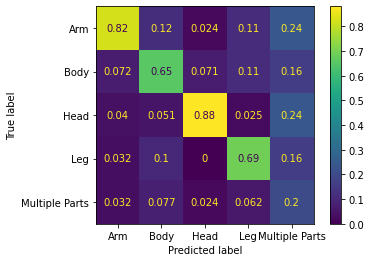

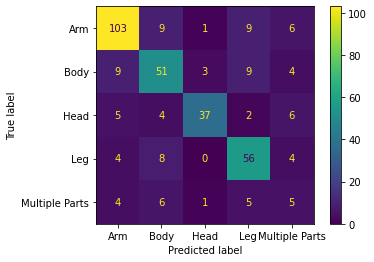

In [38]:
evaulate_performance(y_pred, y_actual, vectorizer)

## LSTM

In [30]:
class LstmRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=True):
        super(LstmRNN, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size,num_layers=1, batch_first=batch_first) 
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        
    def forward(self, x):
        if self.batch_first:
            batch_first_output, (self.hidden, self.cell) = self.lstm(x)
        else:
            batch_first_output, (self.hidden, self.cell) = self.lstm(x)
        return batch_first_output[:, -1]

In [31]:
classifier = IBPClassifier(
    embedding_size=embedding_size, 
    num_embeddings=len(vectorizer.NARRATIVE_vocab),
    num_classes=len(vectorizer.target_vocab),
    rnn_hidden_size=256,
    hidden_dim = [128, 64],
    RNN=False,
    padding_idx=vectorizer.NARRATIVE_vocab.mask_index,
    pretrained_embeddings=embeddings
)

In [32]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=0.0002)

train_state = make_train_state(args)

best_val  = {
    'epoch': 0,
    'model_state_dict': 0,
    'optimizer_state_dict': 0,
    'loss': 0,
    'acc':0
}

try:
    for epoch_index in range(200):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset
        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x=batch_dict['x_data'], x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset\
        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x=batch_dict['x_data'], x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        if(best_val['acc']<train_state['val_acc'][-1]):
            best_val  = {
                'epoch': epoch_index,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss,
                'acc': running_acc,
            }

        if epoch_index%10 == 0:
            print('Train loss', round(train_state['train_loss'][-1], 4), 'Train acc', round(train_state['train_acc'][-1], 4), 'Val loss', round(train_state['val_loss'][-1], 4), 'Val acc', round(train_state['val_acc'][-1], 4))
            
        train_state = update_train_state(args=args, model=classifier, train_state=train_state)

except KeyboardInterrupt:
    print("Exiting loop")
torch.save(best_val, "LSTMGlove.h5")

Train loss 1.611 Train acc 20.5067 Val loss 1.6098 Val acc 20.5674
Train loss 1.606 Train acc 20.5067 Val loss 1.6047 Val acc 20.5674
Train loss 1.5957 Train acc 24.4656 Val loss 1.5925 Val acc 27.6596
Train loss 1.5631 Train acc 36.6587 Val loss 1.5521 Val acc 39.0071
Train loss 1.4625 Train acc 45.1306 Val loss 1.4099 Val acc 53.1915
Train loss 1.3161 Train acc 61.9161 Val loss 1.2659 Val acc 65.9574
Train loss 1.1572 Train acc 66.9834 Val loss 1.1009 Val acc 75.1773
Train loss 1.0222 Train acc 72.3674 Val loss 0.9752 Val acc 73.7589
Train loss 0.8772 Train acc 75.6928 Val loss 0.8691 Val acc 71.6312
Train loss 0.7765 Train acc 77.0388 Val loss 0.8226 Val acc 75.8865
Train loss 0.6496 Train acc 79.8892 Val loss 0.7568 Val acc 76.5957
Train loss 0.5789 Train acc 82.4228 Val loss 0.7694 Val acc 74.4681
Train loss 0.4794 Train acc 85.9857 Val loss 0.8074 Val acc 76.5957
Train loss 0.4056 Train acc 87.4901 Val loss 0.7481 Val acc 77.305
Train loss 0.3437 Train acc 89.6279 Val loss 0.7547

In [33]:
checkpoint = torch.load("LSTMGlove.h5")
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
classifier.eval()

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')

batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
running_loss = 0.
running_acc = 0.

classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'], x_lengths=batch_dict['x_length'])
    y_actual = batch_dict['y_target']
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.001885175704956;
Test Accuracy: 76.92307692307693


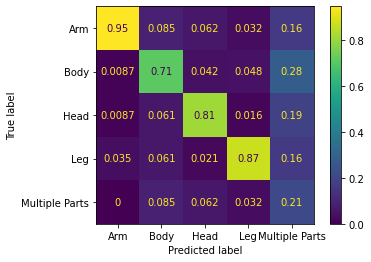

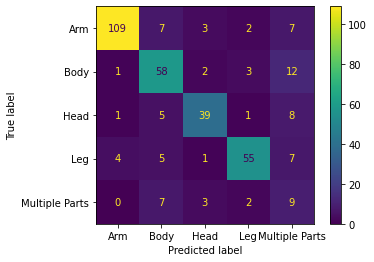

In [34]:
evaulate_performance(y_pred, y_actual, vectorizer)

# NER

## Vocabulary class

## Vector class

## Model

In [41]:
dataset = NERDataset.load_dataset_and_make_vectorizer('data/ner.csv', 'label_txt')
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

In [47]:
device = torch.device('cuda')
INPUT_DIM = len(vectorizer.NARRATIVE_vocab)
OUTPUT_DIM = len(vectorizer.target_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [45]:
criterion = nn.CrossEntropyLoss(ignore_index = vectorizer.target_vocab.mask_index)
optimizer = optim.Adam(model.parameters())

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(11965, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(180, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=180, bias=True)
  )
)

# Bonus